## Identificação:

**Nome: Adriano Ulrich do Prado Wiedmann**

**Matrícula: 202014824**

# Preparação do ambiente, importação e definições gerais

Essa célula é utilizada para montar o Google Drive no ambiente do Google Colab, permitindo o acesso aos arquivos armazenados no Google Drive.

In [1]:
# Importando a biblioteca "drive" do módulo "google.colab"
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


O código da célula seguinte permite a visualização do conteúdo do arquivo utils_exp2.py e permite a importação das funções disponíveis:

In [2]:
import sys

!cat '/content/drive/MyDrive/DPFINAL/utils_exp2.py'
sys.path.append('/content/drive/MyDrive/DPFINAL')

# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# Machine Learning Library
import torch

# work with math and erfc
import math
from scipy.special import erfc

from pylab import *
from sklearn.manifold import TSNE

# Função Q(x)
def func_q(x):
    return (1/2)*erfc((1/math.sqrt(2))*x)

# Detector ótimo para os esquemas tradicionais de modulação
def genareteBER(M, EbNodB_range):
    # gera o vetor de BER para cada uma das modulações tradicionais: M-ASK, M-PSK e M-QAM para 
    # uma dada lista de SNRs
    m_ask = [None]*len(EbNodB_range)
    m_psk = [None]*len(EbNodB_range)
    m_qam = [None]*len(EbNodB_range)
    for n in range(0,len(EbNodB_range)):
        EbNo=10.0**(EbNodB_range[n]/10.0)
        m_ask[n] = 2*(1-(1/M))*func_q((math.sqrt((6*math.log2(M))/(M**2-1)*EbNo)))
        m_psk[n] = 2*func_q(math.sin(math.pi/M)*math.sqrt(2*math.log2(M)*EbNo))
        

A próxima célula é utilizada para importar diversas bibliotecas essencias para a implementação do ***Autoencoder***.


In [3]:
# Importação de NumPy para computação científica
import numpy as np

# Importação de Matplotlib para visualização
import matplotlib.pyplot as plt
%matplotlib inline

# Importação do módulo de otimização do Scipy
from scipy import optimize

# Importação do PyTorch para aprendizado de máquina
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

# Importação de módulos matemáticos e funções especiais
import math
from scipy.special import erfc

# Importação de módulos adicionais para visualização
from pylab import *
from sklearn.manifold import TSNE

# Importação de funções complementares
import utils_exp2

# Arquitetura autoencoder
A próxima célula define a classe autoencoder, que é uma rede neural utilizada para compressão e reconstrução de dados. A arquitetura do autoencoder é composta por um encoder e um decoder, com uma camada de ruído entre eles. Além da normalização na saída no encoder.

---
# Informações sobre o código:


*   A classe autoencoder herda de `nn.Module`, a classe base para todas as redes neurais em PyTorch.
*   O método **`__init__`** inicializa o autoencoder, definindo as camadas do encoder e decoder

*   O encoder consiste em uma camada linear que transforma a entrada de dimensão **`M`** para **`n_channel*n_simbolos`**. O encoder contém uma função de ativação **ReLU**. E uma camada de normalização em ***batch*** para estabilizar e acelerar o treinamento.
*   O decoder consiste em uma camada linear que transforma a entrada de **`n_channel*n_simbolos`** para **`M`**. O decoder também contém uma função de ativação **ReLU**. E por fim, uma camada de ativação **Softmax**.




In [4]:
# Definição da Classe Autoencoder
class autoencoder(nn.Module):
    def __init__(self,M, n_channel, n_simbolos):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(M, n_channel*n_simbolos),
            nn.ReLU(True),
            nn.Linear(n_channel*n_simbolos, n_channel*n_simbolos),
            nn.BatchNorm1d(n_channel*n_simbolos, affine=True))
        self.decoder = nn.Sequential(
            nn.Linear(n_channel*n_simbolos, M),
            nn.ReLU(True),
            nn.Linear(M, M),
            nn.Softmax())

    def forward(self, x, R, n_channel, n_simbolos, EbN0):
        outs = {}
        # Número de linhas de x
        x_size = x.shape[0]

        # Encoder Layer
        x = self.encoder(x)
        # Normalização Euclidiana
        x = nn.functional.normalize(x, p=2, dim=-1)
        x = x*math.sqrt(n_channel)
        # Saída do vetor de codificado e normalizado
        outs['encoded'] = x

        # Para a influência do canal, adiciona-se ruído à saída do encoder
        noise_channel = torch.normal(0.0, math.sqrt(1/(2*R*(10.0**(EbN0/10.0)))),[x_size, n_channel*n_simbolos])
        x = x + noise_channel
        outs['encoded_noise'] = x

        # Decoder Layer
        x = self.decoder(x)
        # Saída do vetor de decodificado
        outs['decoded'] = x
        return outs

    def auto_encoder(self, x, n_channel, n_simbolos):
        x = self.encoder(x)
        x = nn.functional.normalize(x, p=2, dim=-1)
        x = x*math.sqrt(n_channel)
        return x

    def auto_decoder(self, x):
        x = self.decoder(x)
        return x

# Função de treinamento

A função `train_autoencoder` realiza o treinamento de um autoencoder, configurando os parâmetros de treinamento, criando o *dataset*, definindo a função de perda e o otimizador, e executando o laço de treinamento para atualizar os parâmetros do modelo. Ao final, retorna os valores de perda para cada época, que podem ser utilizados para avaliar a performance do treinamento.

# Sobre o código:


*   `torch.eye(M)` Cria uma matriz identidade de dimensão M x M;
*   `data = train_dataset.repeat(int(N_treino/M), 1)`  Repete a matriz identidade até que o número total de amostras de treinamento (`N_treino`) seja alcançado ;


*   `criterion = nn.CrossEntropyLoss()` Define a função de perda como *CrossEntropy Loss*.
*   `optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)` Utiliza o algoritmo Adam para otimização dos parâmetros do modelo


*   `loss_epoch = []` armazena o valor da perda em cada época;






In [5]:
def train_autoencoder(k, n_channel, n_simbolos, model):

  # Quantidade de mensagens
  M = 2**k
  # Taxa de bits por uso do canal
  R = k/n_channel
  # Relação sinal-ruído
  EbN0 = 7

  # Taxa de aprendizado
  learning_rate = 1e-3

  # Número de épocas de treinamento
  num_epochs = 2000

  # Tamanho do conjunto de cada treinamento - batch size
  batch_size = 10*M

  # Quantidade de amostras de treinamento
  N_treino = batch_size*10


  # Criação do dataset de treino
  train_dataset = torch.eye(M)
  data = train_dataset.repeat(int(N_treino/M),1)

  # Função de perda do treinamento
  criterion = nn.CrossEntropyLoss()

  # Algortimo de otimização
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

  # Para guardar os valores de loss
  loss_epoch = []

  for epoch in range(num_epochs):
      # Definição do dataset (aleatório para cada época)
      dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

      # Para cada batch size em 'dataloader'
      for input_in in dataloader:
          # Forward
          output = model(input_in,R,n_channel, n_simbolos,EbN0)
          target_crossEntropy = torch.argmax(input_in, dim=-1).type(torch.LongTensor)
          loss = criterion(output['decoded'], target_crossEntropy)
          # Backward
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      loss_epoch.append(loss.data)

  return loss_epoch

# Função de plotagem da evolução do processo de treinamento

Essa função `plot_loss(loss_epoch)` cria um gráfico que mostra a evolução da função de perda (*loss*) ao longo das épocas de treinamento de um modelo autoencoder. Tal função utiliza os valores de `loss_epoch` para plotar a perda em função do número de épocas.

In [12]:
def plot_loss(loss_epoch, n_channel, k):
  # Plot da curva de Loss
  vector_loss = np.arange(0,len(loss_epoch),1)
  fig = plt.figure(figsize=(10,8))
  plt.plot(vector_loss,loss_epoch,'b',label='Autoencoder(%d,%d)'%(n_channel, k))
  plt.xlabel('Epoca')
  plt.ylabel('Loss')
  plt.title('Loss por Época')
  plt.legend(loc='lower left',ncol = 1)
  plt.grid()
  plt.show()

# Função de teste

A função teste avalia a performance do autoencoder em diferentes valores de relação sinal-ruído (Eb/N0). Ela gera dados de teste, aplica ruído, codifica e decodifica os sinais. E calcula a taxa de erro de símbolo.

# Sobre o código:


*  `EbNodB_range = torch.arange(0,8,0.5)` define a faixa de valores de Eb/N0 (razão energia por bit para densidade espectral de ruído) em decibéis (dB);
*   `ser = [None]*len(EbNodB_range)` inicializa uma lista para armazenar as taxas de erro de símbolo (SER) para cada valor de Eb/N0;


*   `EbNo = 10.0**(EbNodB_range[n]/10.0)` converte Eb/N0 de dB para uma escala linear;
*   `noise_std = np.sqrt(1/(2*R*EbNo)).item()` calcula o desvio padrão do ruído;


*   `noise_mean = 0.0` define a média do ruído como zero;
*   `noise = torch.normal(noise_mean, noise_std, [N_teste, n_channel*n_simbolos])` gera ruído normal com a média e desvio padrão calculados;


*   `data = TensorDataset(test_data, torch.LongTensor(test_label))` cria um dataloader para embaralhar os dados de teste;
*   `test_data_ = dataloader_test.dataset.tensors[0]` extrai os dados de teste do dataloader;


*   `label_=np.array(dataloader_test.dataset.tensors[1])` extrai as *labels* de teste do dataloader;
*   `channel_signal = encoded_signal + noise` adiciona ruído ao sinal codificado.











In [7]:
def teste(k, n_channel, n_simbolos, model):
  # Quantidade de mensagens
  M = 2**k
  # Taxa de bits por uso do canal
  R = k/n_channel

  # Paramêtros de Teste
  N_teste = 100000*M
  test_label = torch.randint(0, M, (N_teste,))
  test_data = torch.nn.functional.one_hot(test_label).float()

  # Variáveis de teste
  EbNodB_range = torch.arange(0,8,0.5)
  ser = [None]*len(EbNodB_range)########

  for n in range(0,len(EbNodB_range)):
      EbNo=10.0**(EbNodB_range[n]/10.0)
      noise_std = np.sqrt(1/(2*R*EbNo)).item()
      noise_mean = 0.0
      no_errors = 0
      noise = torch.normal(noise_mean, noise_std,[N_teste, n_channel*n_simbolos])

      # Embaralhamneto do dataset de teste
      data = TensorDataset(test_data, torch.LongTensor(test_label))
      dataloader_test = DataLoader(data, batch_size=N_teste, shuffle=True)

      # Dividindo o dataset em labels e dados
      test_data_ = dataloader_test.dataset.tensors[0]
      label_ = np.array(dataloader_test.dataset.tensors[1])

      # Codificação do sinal
      encoded_signal = model.auto_encoder(test_data_, n_channel, n_simbolos)

      # Influencia do Canal
      channel_signal = encoded_signal + noise

      # Decodificação do sinal
      pred_final_signal = model.auto_decoder(channel_signal)
      parse_pred_output = pred_final_signal.tolist()
      pred_output = np.argmax(parse_pred_output,axis=1)   #retorna um array com a posição de maior argumento

      no_errors = (pred_output != label_)
      no_errors =  no_errors.astype(int).sum()
      ser[n] = no_errors / N_teste

  return EbNodB_range, ser

# Função de resultado do encoder

A função result é responsável por exibir os resultados do treinamento do autoencoder e compará-los com resultados teóricos para modulação PSK ou QAM.

In [8]:
def result(n_channel, n_simbolos, k, loss_epoch, EbNodB_range, ser, psk, model):
  # Curvas do detector ótimo
  ask_M, psk_M, qam_M = utils_exp2.genareteBER(2**k, EbNodB_range)

  fig = plt.figure(figsize=(10,8))
  fig_title = "Curvas de BLER para Autoencoder("+str(n_channel)+","+str(k)+")"
  if psk:
    plt.plot(EbNodB_range, psk_M, 'ko',label='Teorico-PSK')
  else:
    plt.plot(EbNodB_range, qam_M, 'ko',label='Teorico-QAM')
  plt.plot(EbNodB_range, ser, 'bo', label='Autoencoder(%d,%d)'%(n_channel, k))
  plt.yscale('log')
  plt.xlabel('SNR Range')
  plt.ylabel('BLER')
  plt.title(fig_title)
  plt.grid()
  plt.legend(loc='lower left',ncol = 1)
  plt.show()


  # Mensagens codificadas pelo Encoder
  data_encoded_symbol = model.auto_encoder(torch.eye(2**k),n_channel, n_simbolos)

  # Separação dos símbolos em real e imaginário
  real_symb, imag_symb = utils_exp2.split_symb(data_encoded_symbol)

  # Plotagem das constelações por uso do canal
  utils_exp2.plot_graphs(real_symb.detach().numpy(),imag_symb.detach().numpy(),n_channel,sizefig=5)

# Função de definição dos parâmetros de treino

A função `parameters` realiza uma série de experimentos com diferentes configurações de autoencoder, treinamento, teste e análise de resultados.

In [11]:
def parameters(n_channel, k, n_simbolos, psk_qam):
  # Criação do Autoencoder
  model = autoencoder(2**k, n_channel, n_simbolos)
  # Treinamento do Autoencoder
  loss_epoch = train_autoencoder(k, n_channel, n_simbolos, model)
  # Plotagem da curva de Loss
  plot_loss(loss_epoch, n_channel, k)
  # Teste do Autoencoder
  EbNodB_range, ser = teste(k, n_channel, n_simbolos, model)
  # Resultados
  result(n_channel, n_simbolos, k, loss_epoch, EbNodB_range, ser, psk_qam, model)

# Final
A próxima células excuta série de comandos de experimentos utilizando um autoencoder para diferentes configurações de parâmetros de modulação (PSK ou QAM) e características do canal (número de canais, taxa de bits).

n = 1; k = 2; modulação PSK


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


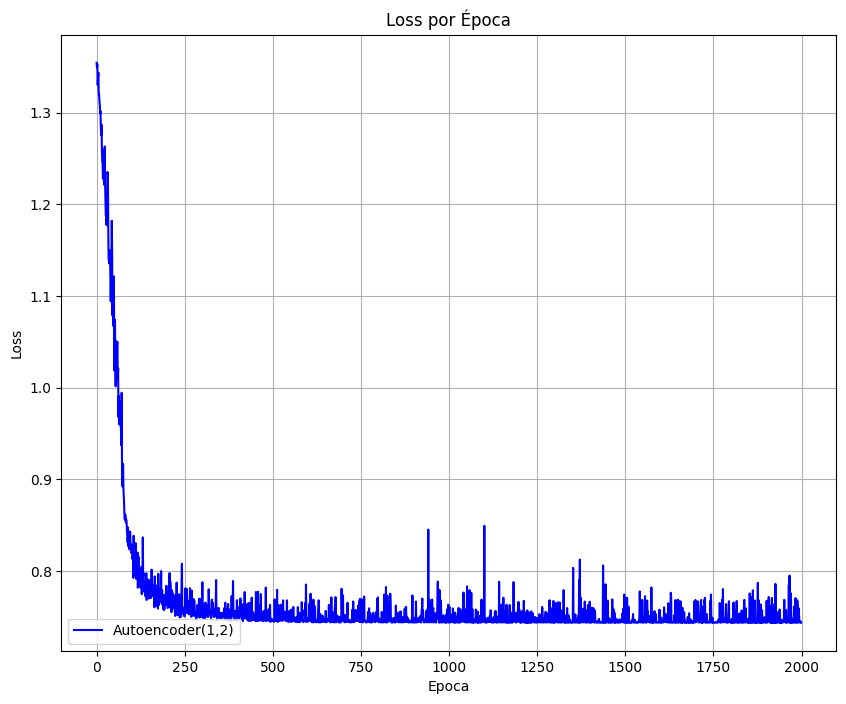

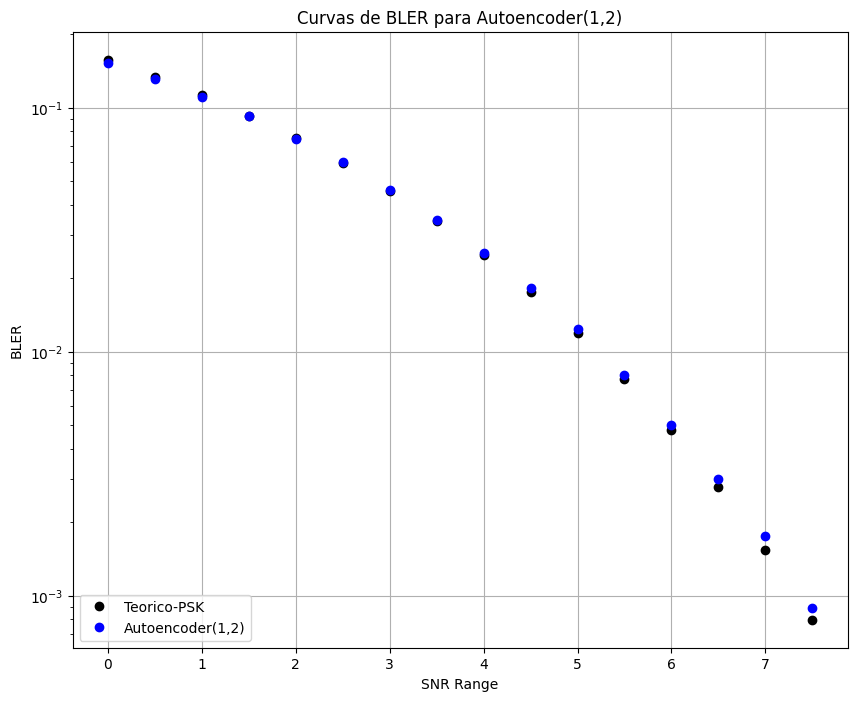

<Figure size 640x480 with 0 Axes>

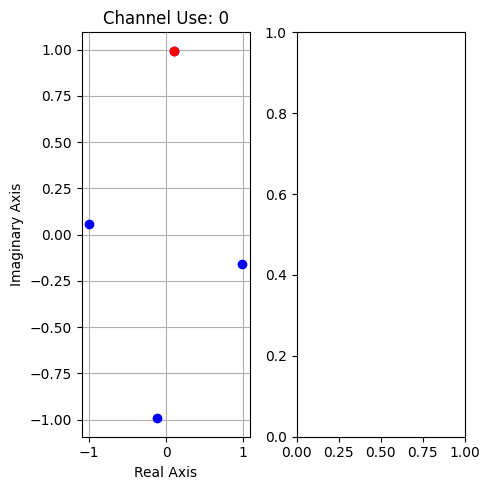

n = 2; k = 2; modulação PSK


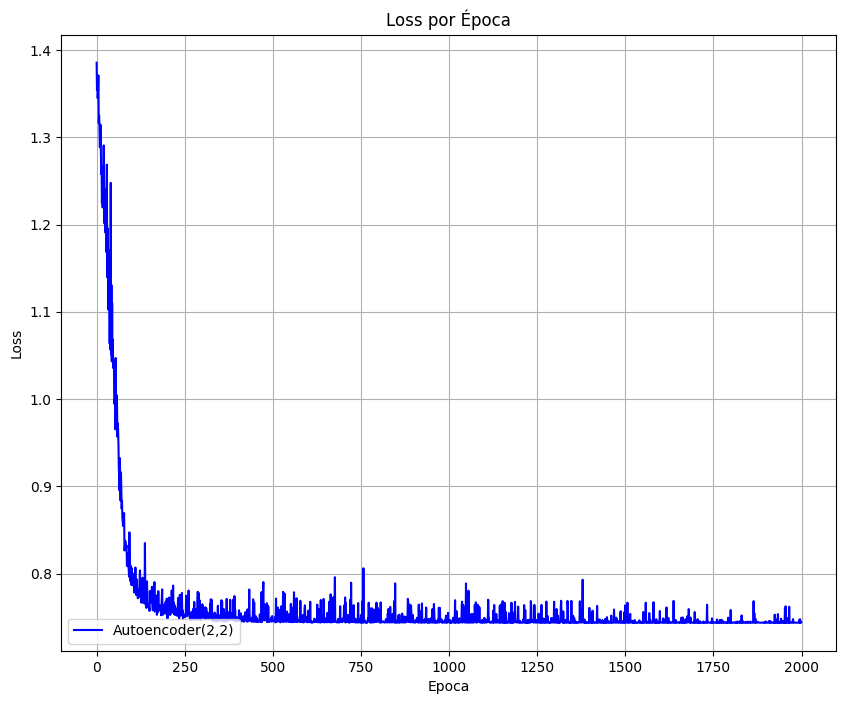

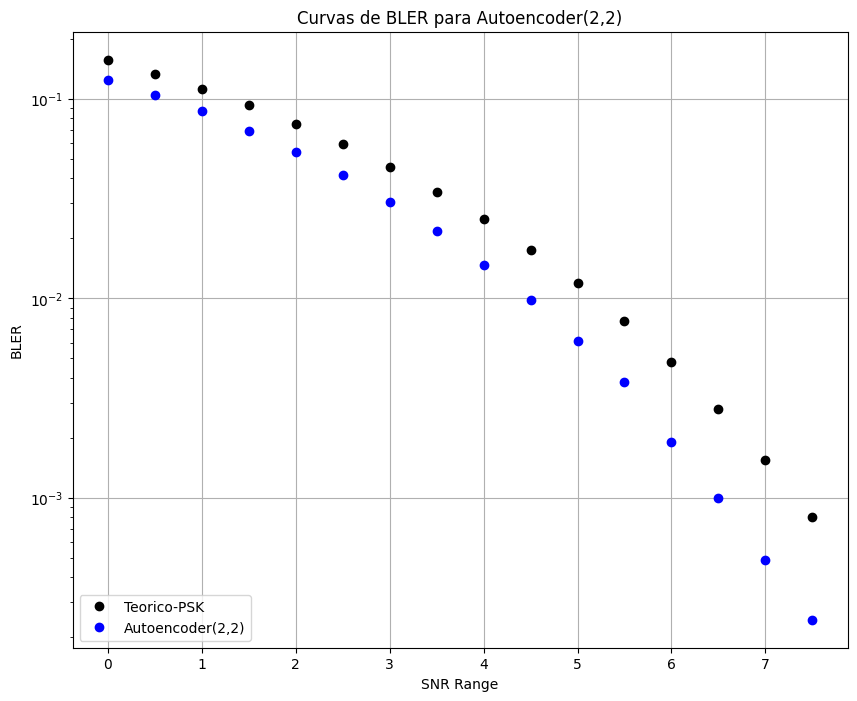

<Figure size 640x480 with 0 Axes>

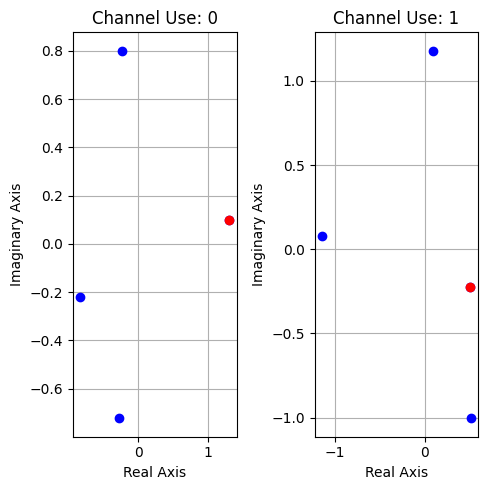

n = 3; k = 2; modulação QAM


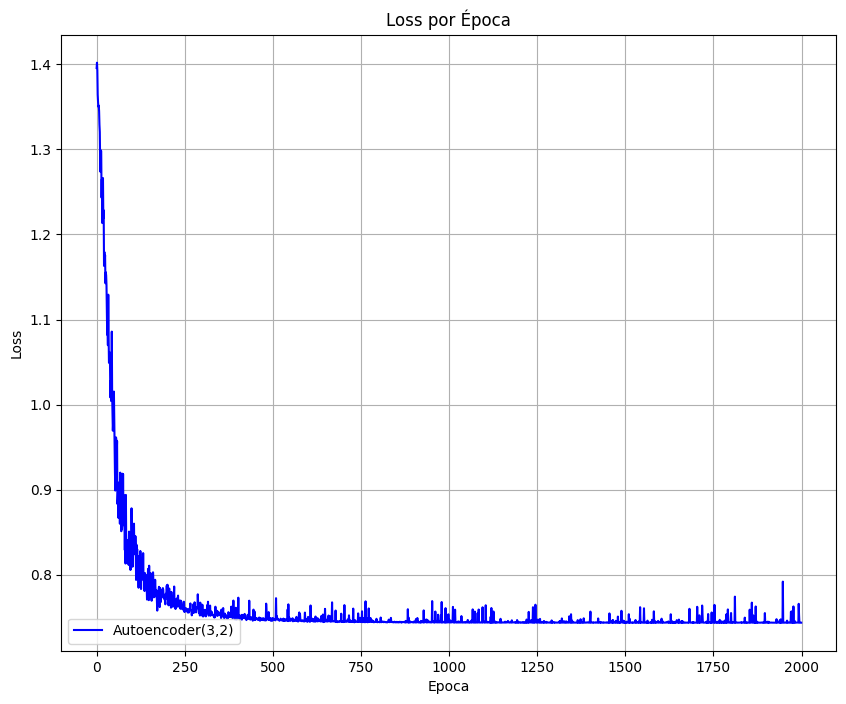

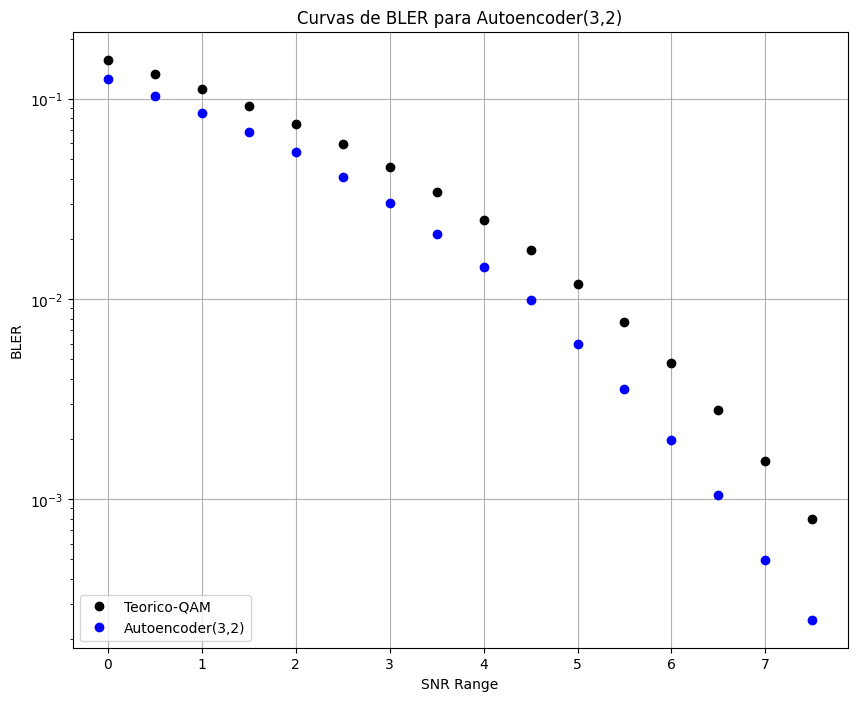

<Figure size 640x480 with 0 Axes>

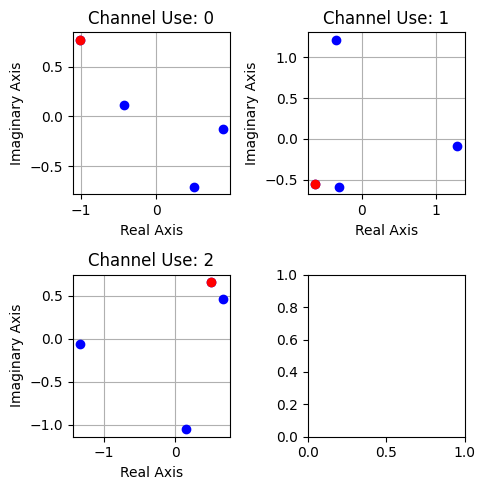

n = 2; k = 3; modulação PSK


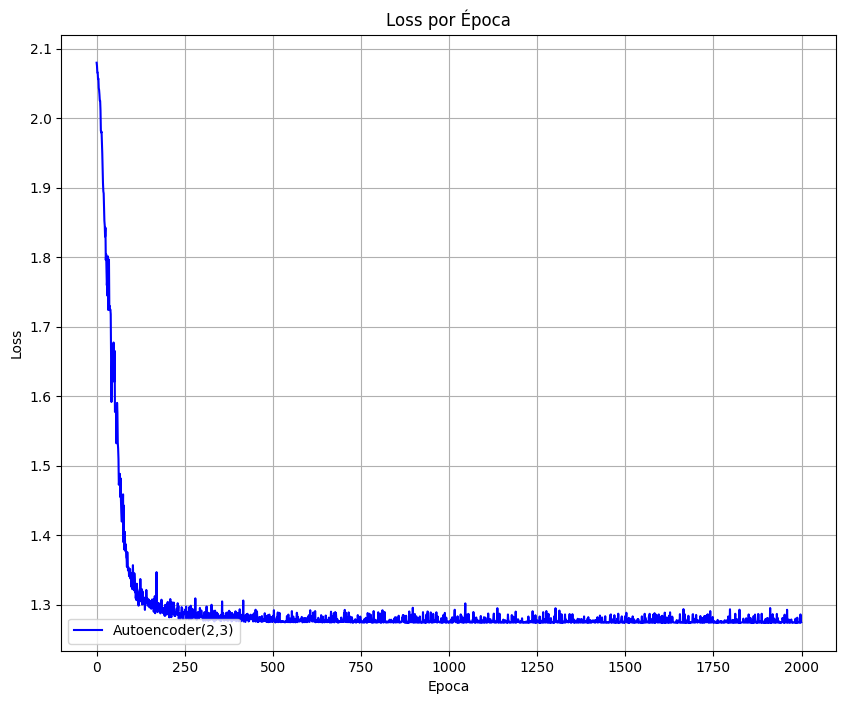

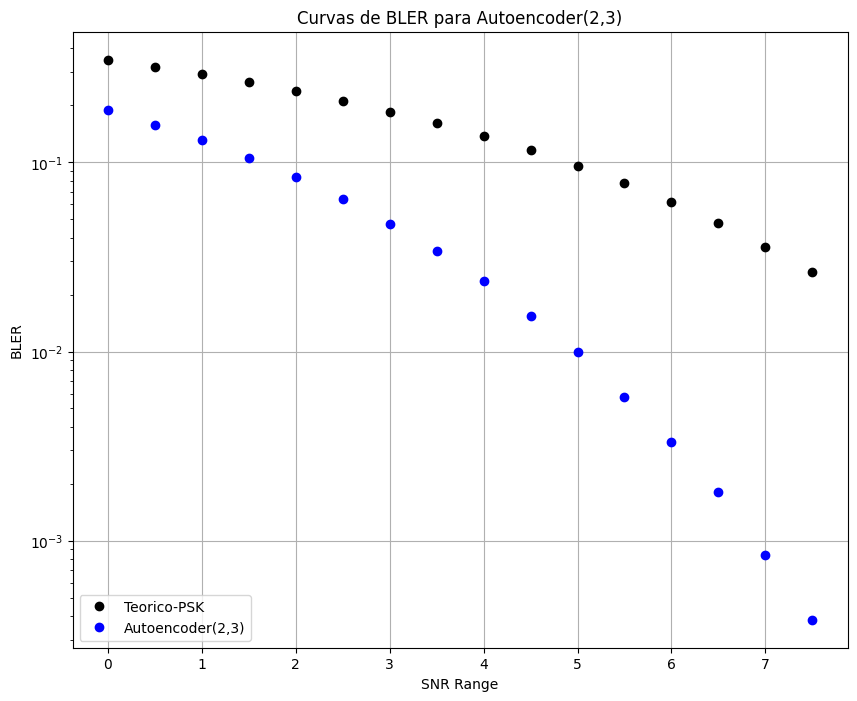

<Figure size 640x480 with 0 Axes>

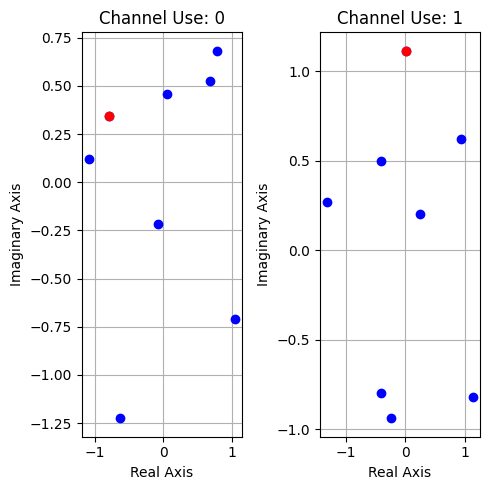

n = 2; k = 3; modulação QAM


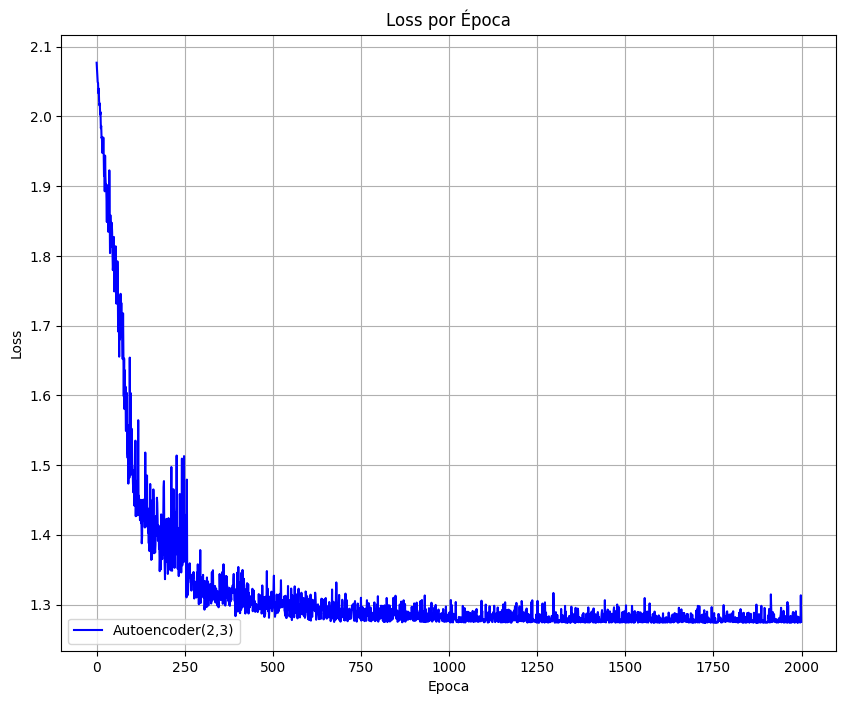

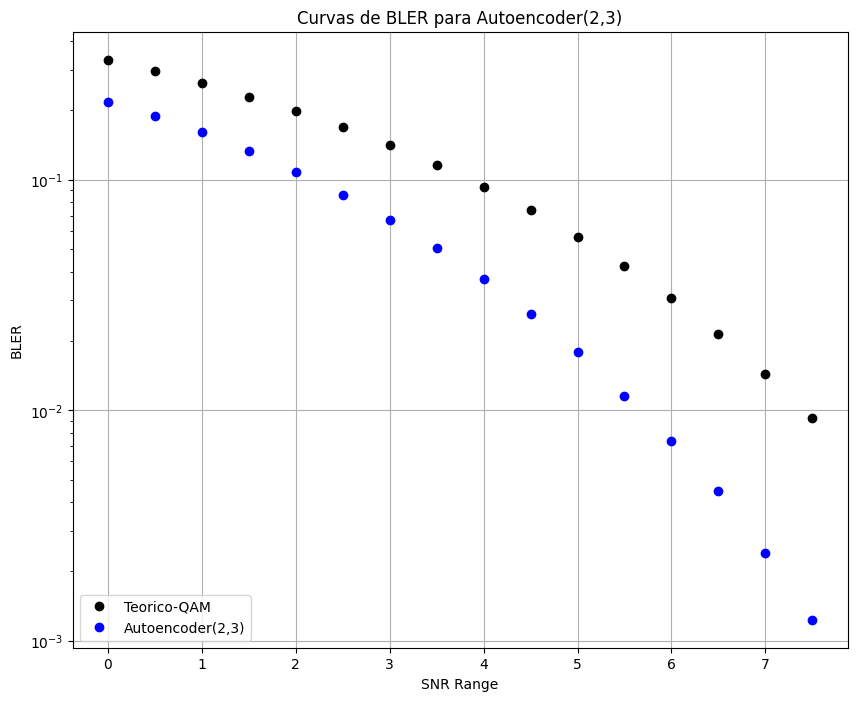

<Figure size 640x480 with 0 Axes>

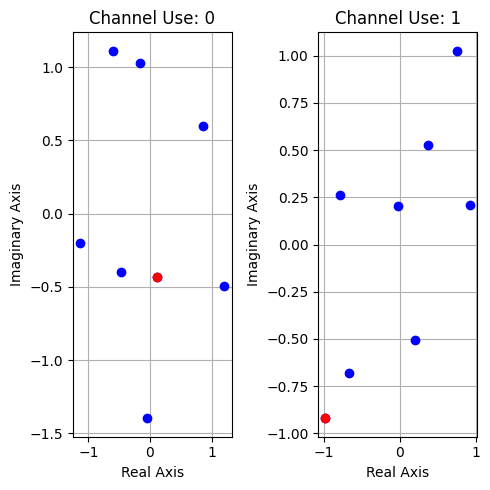

In [13]:
# n = 1; k = 2; modulação PSK
print("n = 1; k = 2; modulação PSK")
parameters(1, 2, 2, 1)

# n = 2; k = 2; modulação PSK
print("n = 2; k = 2; modulação PSK")
parameters(2, 2, 2, 1)

# n = 3; k = 2; modulação QAM
print("n = 3; k = 2; modulação QAM")
parameters(3, 2, 2, 0)

# n = 2; k = 3; modulação PSK
print("n = 2; k = 3; modulação PSK")
parameters(2, 3, 2, 1)

# n = 2; k = 3; modulação QAM
print("n = 2; k = 3; modulação QAM")
parameters(2, 3, 2, 0)